# Compression

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorkrowch as tk

In [2]:
torch.set_num_threads(1)
cwd = os.getcwd()

## Tensorized models

In [3]:
embedding_fn = 'poly',
embed_dim = 2
domain_multiplier = 1
n_samples = 100

bond_dim_lst = ['Baseline', 2, 5, 10]
models_lst = ['Tiny', 'Medium', 'Large']


models_dir = os.path.join(cwd, '..', '..', 'results', '2_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]


# Get max accuracies by bond_dim
max_accs_bond_dim_lst = [torch.tensor(model_accs)]
for bond_dim in bond_dim_lst[1:]:
    max_accs_lst = []
    for model in models_lst:
        cores_dir = os.path.join(
            models_dir,
            f'recores_fffc_{model.lower()}')
        cores_file = list(filter(lambda f: f.startswith(f'{bond_dim}'),
                                 os.listdir(cores_dir)))[0]
        
        max_accs_lst.append(torch.tensor(float(cores_file.split('_')[-2])))
    
    max_accs_bond_dim_lst.append(torch.stack(max_accs_lst, dim=0))

max_accs_bond_dim = torch.stack(max_accs_bond_dim_lst, dim=0)

## Re-trained tensorized models

In [4]:
embedding_fn = 'poly',
embed_dim = 2
domain_multiplier = 1
n_samples = 100

bond_dim_lst = ['Baseline', 2, 5, 10]
models_lst = ['Tiny', 'Medium', 'Large']

models_dir = os.path.join(cwd, '..', '..', 'results', '2_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]


# Get max accuracies by bond_dim
max_accs_bond_dim_lst = [torch.tensor(model_accs)]
for bond_dim in bond_dim_lst[1:]:
    max_accs_lst = []
    for model in models_lst:
        cores_dir = os.path.join(
            models_dir,
            f'recores_fffc_{model.lower()}')
        cores_file = list(filter(lambda f: f.startswith(f'{bond_dim}'),
                                 os.listdir(cores_dir)))[0]
        
        max_accs_lst.append(torch.tensor(float(cores_file.split('_')[-1][:-3])))
    
    max_accs_bond_dim_lst.append(torch.stack(max_accs_lst, dim=0))

max_accs_bond_dim_retrained = torch.stack(max_accs_bond_dim_lst, dim=0)

In [5]:
def n_params_mps(phys_dim, bond_dim_lst):
    n = len(bond_dim_lst) + 1
    
    s = 0
    for i in range(1, n - 1):
        s += phys_dim * bond_dim_lst[i - 1] * bond_dim_lst[i]
    
    s += phys_dim * bond_dim_lst[0]
    s += phys_dim * bond_dim_lst[-1]
    
    return s

In [6]:
def n_ops_mps(phys_dim, bond_dim_lst):
    n = len(bond_dim_lst) + 1
    
    s = 0
    for i in range(1, n - 1):
        s += phys_dim * bond_dim_lst[i - 1] * bond_dim_lst[i]
    
    s += phys_dim * bond_dim_lst[0]
    s += phys_dim * bond_dim_lst[-1]
    
    for i in range(n - 2):
        s += bond_dim_lst[i] * bond_dim_lst[i + 1]
    
    s += bond_dim_lst[-1]
    
    return s

In [7]:
# Get times
embedding_fn = 'poly',
embed_dim = 2
domain_multiplier = 1
n_samples = 100

bond_dim_lst = ['Baseline', 2, 5, 10]
models_lst = ['Tiny', 'Medium', 'Large']

models_dir = os.path.join(cwd, '..', '..', 'results', '2_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]
model_accs = torch.tensor(model_accs)


# Get max accuracies by bond_dim
n_params_bond_dim_lst = [torch.zeros_like(model_accs)]
n_ops_bond_dim_lst = [torch.zeros_like(model_accs)]
max_accs_bond_dim_lst = [model_accs]
for bond_dim in bond_dim_lst[1:]:
    n_params_lst = []
    n_ops_lst = []
    max_accs_lst = []
    for model in models_lst:
        cores_dir = os.path.join(
            models_dir,
            f'recores_fffc_{model.lower()}')
        cores_file = list(filter(lambda f: f.startswith(f'{bond_dim}'),
                                 os.listdir(cores_dir)))[0]
        
        best_cores = torch.load(os.path.join(cores_dir, cores_file))
        tn_model = tk.models.MPSLayer(tensors=best_cores)
        
        n_params_lst.append(torch.tensor(n_params_mps(2, tn_model.bond_dim)))
        n_ops_lst.append(torch.tensor(n_ops_mps(2, tn_model.bond_dim)))
        max_accs_lst.append(torch.tensor(float(cores_file.split('_')[-1][:-3])))
    
    n_params_bond_dim_lst.append(torch.stack(n_params_lst, dim=0))
    n_ops_bond_dim_lst.append(torch.stack(n_ops_lst, dim=0))
    max_accs_bond_dim_lst.append(torch.stack(max_accs_lst, dim=0))

n_params_bond_dim = torch.stack(n_params_bond_dim_lst, dim=0)
n_ops_bond_dim = torch.stack(n_ops_bond_dim_lst, dim=0)
max_accs_bond_dim_retrained = torch.stack(max_accs_bond_dim_lst, dim=0)

n_params_bond_dim, n_ops_bond_dim, max_accs_bond_dim_retrained

/tmp/ipykernel_64326/3405155049.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_cores = torch.load(os.path.join(cores_dir, cores_file))


(tensor([[    0.,     0.,     0.],
         [ 4000.,  3994.,  4000.],
         [24808., 24742., 24856.],
         [95848., 96196., 98116.]]),
 tensor([[     0.,      0.,      0.],
         [  5998.,   5989.,   5998.],
         [ 37210.,  37111.,  37282.],
         [143770., 144292., 147172.]]),
 tensor([[0.8493, 0.8548, 0.8640],
         [0.7630, 0.8116, 0.7960],
         [0.7960, 0.8108, 0.7856],
         [0.7891, 0.7786, 0.7917]]))

## LW-tensorized models

In [ ]:
bond_dim_lst = ['Baseline', 2, 5, 10]
models_lst = ['Tiny', 'Medium', 'Large']

models_dir = os.path.join(cwd, '..', '..', 'results', '2_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]


sizes_bond_dim_lst = []
accs_bond_dim_lst = [torch.tensor(model_accs)]
for bond_dim in bond_dim_lst[1:]:
    sizes_models_lst = []
    accs_models_lst = []
    for model in models_lst:
        model_dir = os.path.join(models_dir,
                                f'fffc_{model.lower()}_tn')
        model_file = list(filter(lambda f: f.startswith(f'{bond_dim}_'),
                                 os.listdir(model_dir)))[0].split('_')
        
        model_size = int(model_file[2])
        model_acc = float(model_file[3])
    
        sizes_models_lst.append(model_size)
        accs_models_lst.append(model_acc)
    
    sizes_bond_dim_lst.append(torch.tensor(sizes_models_lst))
    accs_bond_dim_lst.append(torch.tensor(accs_models_lst))
    
sizes_bond_dim = torch.stack(sizes_bond_dim_lst, dim=0)
accs_bond_dim = torch.stack(accs_bond_dim_lst, dim=0)

sizes_bond_dim, accs_bond_dim

(tensor([[ 384,  618, 1070],
         [1287, 2163, 3764],
         [3512, 5238, 8838]]),
 tensor([[0.8493, 0.8548, 0.8640],
         [0.7614, 0.7500, 0.4801],
         [0.8229, 0.8248, 0.8011],
         [0.8428, 0.8598, 0.8314]]))

## Re-trained LW-tensorized models

In [9]:
bond_dim_lst = ['Baseline', 2, 5, 10]
models_lst = ['Tiny', 'Medium', 'Large']

models_dir = os.path.join(cwd, '..', '..', 'results', '2_compression')

# Baseline accuracies
model_files = [
    list(filter(lambda f: f.startswith(f'fffc_{model.lower()}') and f.endswith('.pt'),
                os.listdir(models_dir)))[0]
    for model in models_lst]
model_accs = [float(file.split('_')[-1][:-3]) for file in model_files]


sizes_bond_dim_lst = []
accs_bond_dim_lst = [torch.tensor(model_accs)]
for bond_dim in bond_dim_lst[1:]:
    sizes_models_lst = []
    accs_models_lst = []
    for model in models_lst:
        model_dir = os.path.join(models_dir,
                                f'fffc_{model.lower()}_tn')
        model_file = list(filter(lambda f: f.startswith(f'{bond_dim}_'),
                                 os.listdir(model_dir)))[0].split('_')
        
        model_size = int(model_file[2])
        model_acc = float(model_file[4][:-3])
    
        sizes_models_lst.append(model_size)
        accs_models_lst.append(model_acc)
    
    sizes_bond_dim_lst.append(torch.tensor(sizes_models_lst))
    accs_bond_dim_lst.append(torch.tensor(accs_models_lst))

sizes_bond_dim = torch.stack(sizes_bond_dim_lst, dim=0)
accs_bond_dim_retrained = torch.stack(accs_bond_dim_lst, dim=0)

sizes_bond_dim, accs_bond_dim_retrained

(tensor([[ 384,  618, 1070],
         [1287, 2163, 3764],
         [3512, 5238, 8838]]),
 tensor([[0.8493, 0.8548, 0.8640],
         [0.8324, 0.8438, 0.8239],
         [0.8362, 0.8580, 0.8295],
         [0.8532, 0.8598, 0.8314]]))

In [ ]:
from functools import reduce
from operator import mul

def prod(lst):
    return reduce(mul, lst)

# N ops TNNs
def n_ops_mpo(bond_dim, mpo):
    in_dims = list(mpo[0])
    out_dims = list(mpo[1])
    assert len(in_dims) == len(out_dims)
    
    n = len(in_dims)
    
    s = 0
    s += prod(in_dims[1:]) * in_dims[0] * bond_dim * out_dims[0]
    
    for i in range(1, n - 1):
        s += prod(in_dims[(i + 1):]) * prod(out_dims[:i]) * in_dims[i] * \
            bond_dim * out_dims[i] * bond_dim
    
    s += prod(out_dims[:n]) * in_dims[n - 1] * bond_dim * out_dims[n - 1]
    
    return s


def n_ops_tnn(bond_dim, *mpo_lst):
    s = 0
    for mpo in mpo_lst:
        s += n_ops_mpo(bond_dim, mpo)
    
    return s


# Tiny
n_ops_tiny = [n_ops_tnn(2, *[((2, 5, 5, 5, 2), (1, 5, 5, 2, 1)),
                             ((2, 5, 5), (1, 2, 1))]),
              n_ops_tnn(5, *[((2, 5, 5, 5, 2), (1, 5, 5, 2, 1)),
                             ((2, 5, 5), (1, 2, 1))]),
              n_ops_tnn(10, *[((2, 5, 5, 5, 2), (1, 5, 5, 2, 1)),
                              ((2, 5, 5), (1, 2, 1))])]

# Medium
n_ops_medium = [n_ops_tnn(2, *[((2, 5, 5, 5, 2), (2, 5, 5, 2, 1)),
                               ((2, 5, 5, 2), (2, 5, 2, 1)),
                               ((2, 5, 2), (1, 2, 1))]),
                n_ops_tnn(5, *[((2, 5, 5, 5, 2), (2, 5, 5, 2, 1)),
                               ((2, 5, 5, 2), (2, 5, 2, 1)),
                               ((2, 5, 2), (1, 2, 1))]),
                n_ops_tnn(10, *[((2, 5, 5, 5, 2), (2, 5, 5, 2, 1)),
                               ((2, 5, 5, 2), (2, 5, 2, 1)),
                               ((2, 5, 2), (1, 2, 1))])]

# Large
n_ops_large = [n_ops_tnn(2, *[((2, 5, 5, 5, 2), (2, 5, 5, 2, 2)),
                              ((2, 5, 5, 2, 2), (2, 5, 5, 2, 1)),
                              ((2, 5, 5, 2), (2, 5, 2, 1)),
                              ((2, 5, 2), (1, 2, 1))]),
               n_ops_tnn(5, *[((2, 5, 5, 5, 2), (2, 5, 5, 2, 2)),
                              ((2, 5, 5, 2, 2), (2, 5, 5, 2, 1)),
                              ((2, 5, 5, 2), (2, 5, 2, 1)),
                              ((2, 5, 2), (1, 2, 1))]),
               n_ops_tnn(10, *[((2, 5, 5, 5, 2), (2, 5, 5, 2, 2)),
                               ((2, 5, 5, 2, 2), (2, 5, 5, 2, 1)),
                               ((2, 5, 5, 2), (2, 5, 2, 1)),
                               ((2, 5, 2), (1, 2, 1))])]

n_ops_tnn = torch.stack([torch.tensor(n_ops_tiny),
                         torch.tensor(n_ops_medium),
                         torch.tensor(n_ops_large)], dim=1)

n_ops_tnn


tensor([[ 13520,  29808,  41808],
        [ 79550, 175320, 241320],
        [311600, 686640, 938640]])

# Figure

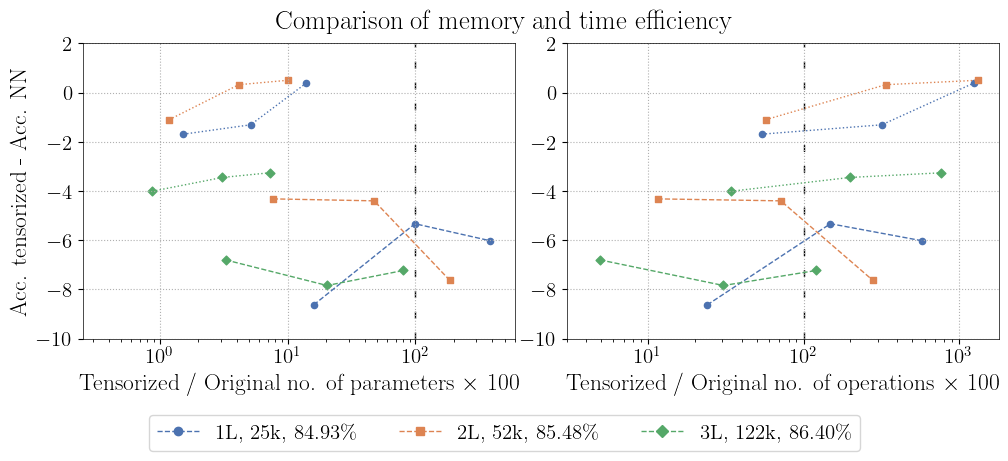

In [ ]:
palette = sns.color_palette("deep")
colors = palette[0], palette[1], palette[2], palette[3]

plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)


# Set global font sizes
plt.rcParams['axes.linewidth'] = 0.5  # Default is usually 1.0
plt.rcParams['axes.titlesize'] = 19  # Title font size
plt.rcParams['axes.labelsize'] = 17  # Axis label font size
plt.rcParams['xtick.labelsize'] = 15  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 15  # Y-axis tick label font size
plt.rcParams['legend.fontsize'] = 15


fig, axs = plt.subplots(1, 2, figsize=(10, 4))


markers = ['o', 's', 'D', '^']
labels = [f'1L, 25k, {100*model_accs[0]:.2f}\%',
          f'2L, 52k, {100*model_accs[1]:.2f}\%',
          f'3L, 122k, {100*model_accs[2]:.2f}\%']
model_sizes = {'Tiny': 25000,
               'Medium': 52000,
               'Large': 122000}

# Paramaters
# ==========

# Accuracies tensorized models
# ----------------------------
mps_params = n_params_bond_dim.t()[:, 1:]
mps_ops = n_ops_bond_dim.t()[:, 1:]

aux_accs = max_accs_bond_dim_retrained.t()
diff_accs_retrained = (aux_accs[:, 1:] - aux_accs[:, :1]) * 100

tuples = zip(model_sizes.keys(), mps_params, mps_ops, diff_accs_retrained)

axs[0].axvline(x=100, linestyle=(0, (5, 10)), linewidth=1., color='black', zorder=-1)

for i, (model_name, params, ops, dar) in enumerate(tuples):
    x = (params / model_sizes[model_name]) * 100
    
    axs[0].plot(x, dar, linestyle='--', linewidth=1., color=colors[i])
    axs[0].scatter(x=x, y=dar, s=20., marker=markers[i], label=labels[i], color=colors[i])


# Accuracies lw-tensorized models
# -------------------------------
tnn_ops = n_ops_tnn.t()

aux_accs = accs_bond_dim_retrained.t()
diff_accs_retrained = (aux_accs[:, 1:] - aux_accs[:, :1]) * 100

tuples = zip(model_sizes.keys(), tnn_ops, diff_accs_retrained, sizes_bond_dim.t())

for i, (model_name, ops, dar, sb) in enumerate(tuples):
    x = (sb[:3] / model_sizes[model_name]) * 100
    
    axs[0].plot(x, dar, linestyle=':', linewidth=1., color=colors[i])
    axs[0].scatter(x=x, y=dar, s=20., marker=markers[i], color=colors[i])

# Set axes
axs[0].set_ylim(-10, 2)
axs[0].set_yticks(torch.arange(-10, 3, 2))

axs[0].set_xscale('log')
axs[0].set_xlim(0.25, 600)


axs[0].grid(axis='y', linestyle=':')
axs[0].grid(axis='x', linestyle=':')

# Adding labels and title
axs[0].set_ylabel('Acc. tensorized - Acc. NN')
axs[0].set_xlabel(r'Tensorized / Original no. of parameters $\times$ 100')


# Operations
# ==========

# Accuracies tensorized models
# ----------------------------
mps_params = n_params_bond_dim.t()[:, 1:]
mps_ops = n_ops_bond_dim.t()[:, 1:]

aux_accs = max_accs_bond_dim_retrained.t()
diff_accs_retrained = (aux_accs[:, 1:] - aux_accs[:, :1]) * 100

tuples = zip(model_sizes.keys(), mps_params, mps_ops, diff_accs_retrained)

axs[1].axvline(x=100, linestyle=(0, (5, 10)), linewidth=1., color='black', zorder=-1)

for i, (model_name, params, ops, dar) in enumerate(tuples):
    x = (ops / model_sizes[model_name]) * 100
    
    axs[1].plot(x, dar, linestyle='--', linewidth=1., color=colors[i])
    axs[1].scatter(x=x, y=dar, s=20., marker=markers[i], label=labels[i], color=colors[i])


# Accuracies lw-tensorized models
# -------------------------------
tnn_ops = n_ops_tnn.t()

aux_accs = accs_bond_dim_retrained.t()
diff_accs_retrained = (aux_accs[:, 1:] - aux_accs[:, :1]) * 100

tuples = zip(model_sizes.keys(), tnn_ops, diff_accs_retrained, sizes_bond_dim.t())

for i, (model_name, ops, dar, sb) in enumerate(tuples):
    x = (ops / model_sizes[model_name]) * 100
    
    axs[1].plot(x, dar, linestyle=':', linewidth=1., color=colors[i])
    axs[1].scatter(x=x, y=dar, s=20., marker=markers[i], color=colors[i])

# Set axes
axs[1].set_ylim(-10, 2)
axs[1].set_yticks(torch.arange(-10, 3, 2))

axs[1].set_xscale('log')
axs[1].set_xlim(3, 1800)


axs[1].grid(axis='y', linestyle=':')
axs[1].grid(axis='x', linestyle=':')

# Adding labels and title
# axs[1].set_ylabel('Difference of accuracies')
axs[1].set_xlabel(r'Tensorized / Original no. of operations $\times$ 100')


fig.suptitle('Comparison of memory and time efficiency')

# Create custom legend handles
from matplotlib.lines import Line2D

custom_handles = [
    Line2D([0], [0], color=color, linestyle='--', marker=marker, markersize=6, linewidth=1., label=label)
    for color, marker, label in zip(colors, markers, labels)
]

# Add a single legend to the figure
fig.legend(
    handles=custom_handles,
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.15),  # Centered below the plots
    # frameon=False
)


plt.tight_layout(pad=0.25)

results_dir = os.path.join(cwd, '..', '..', 'results', '2_compression')
plt.savefig(os.path.join(results_dir, 'compression.pdf'), bbox_inches='tight')

plt.show()